In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import torch
import numpy as np
import torch.nn.functional as F

from PIL import Image
from transformers import AutoModel, AutoTokenizer

class Expert_Distribution:
    
    # Initialize the class with the Hugging Face model path (hf_path)
    def __init__(self, hf_path):
        
        tokenizer = AutoTokenizer.from_pretrained(
            hf_path, 
            trust_remote_code=True
        )

        self.model = AutoModel.from_pretrained(
            hf_path,
            trust_remote_code=True
        ).half().cuda().eval()
        
        self.tokenizer = tokenizer
        self.model.tokenizer = tokenizer
        self.device = self.model.device
    
    # Function to process an image and select token-wise expert modules
    def forward_img_token_wise(self, img_path, top_k=2):
        image = Image.open(img_path).convert('RGB')
        image = self.model.vis_processor(image).unsqueeze(0).to(self.device)
        vit_embeds = self.model.vit(image.to(self.device))
        
        # Compute gate logits, which represent the distribution over expert modules based on the visual embeddings
        gate_logits = self.model.vision_proj.gate(vit_embeds)
        
        # Apply softmax to get probabilities over experts
        gate_softmax = F.softmax(gate_logits, dim=-1, dtype=torch.float).to(vit_embeds.dtype)
        
        # Select the top-k experts based on the highest softmax probabilities
        _, selected_experts = torch.topk(gate_softmax, top_k)
        
        # Return the selected experts, removing the batch dimension
        return selected_experts.squeeze(dim=0)


/data/FinAi_Mapping_Knowledge/qiyiyan/miniconda3/envs/intern_clean/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_edge_on_chart(tester, img_path):
    
    # Define hex color codes and convert them to RGB format for use in visualization
    hex_colors = ['#984ea3','#e41a1c', '#377eb8', '#4daf4a']
    cmap = np.array([tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5)) for hex_color in hex_colors], dtype=np.uint8)
    
    # Run the expert selection process with automatic mixed precision
    with torch.cuda.amp.autocast():
        selected_experts = tester.forward_img_token_wise(img_path, top_k=2)
    selected_experts_top1 = selected_experts[:, 0].view(35, 35)

    image = Image.open(img_path).convert("RGB").resize((490, 490), resample=Image.BICUBIC)
    
    # Upscale expert predictions to match the image size
    selected_experts_top1 = np.repeat(np.repeat(selected_experts_top1.cpu().numpy().astype(np.uint8), 14, axis=0), 14, axis=1)
    expert_colors = cmap[selected_experts_top1]

    # Convert to OpenCV format
    expert_colors_cv = np.array(expert_colors)
    output_image = np.array(image)

    # For each expert color, detect and draw contours on the image
    for color in cmap:
        mask = cv2.inRange(expert_colors_cv, color, color)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output_image, contours, -1, color.tolist(), 2)  # 2 = edge thickness

    # Convert back to PIL format for display
    output_image = Image.fromarray(output_image)

    # Plot the image with edges and create a legend with corresponding colors
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(output_image)
    ax.axis('off')

    # Add color squares as the legend for each expert
    # legend_positions = [(0.85, 0.9), (0.85, 0.85), (0.85, 0.8), (0.85, 0.75)]  # Legend positions
    # for i, (hex_color, position) in enumerate(zip(hex_colors, legend_positions)):
    #     rect = Rectangle(position, 0.05, 0.05, linewidth=1, edgecolor='none', facecolor=hex_color)
    #     ax.add_patch(rect)

    plt.show()  

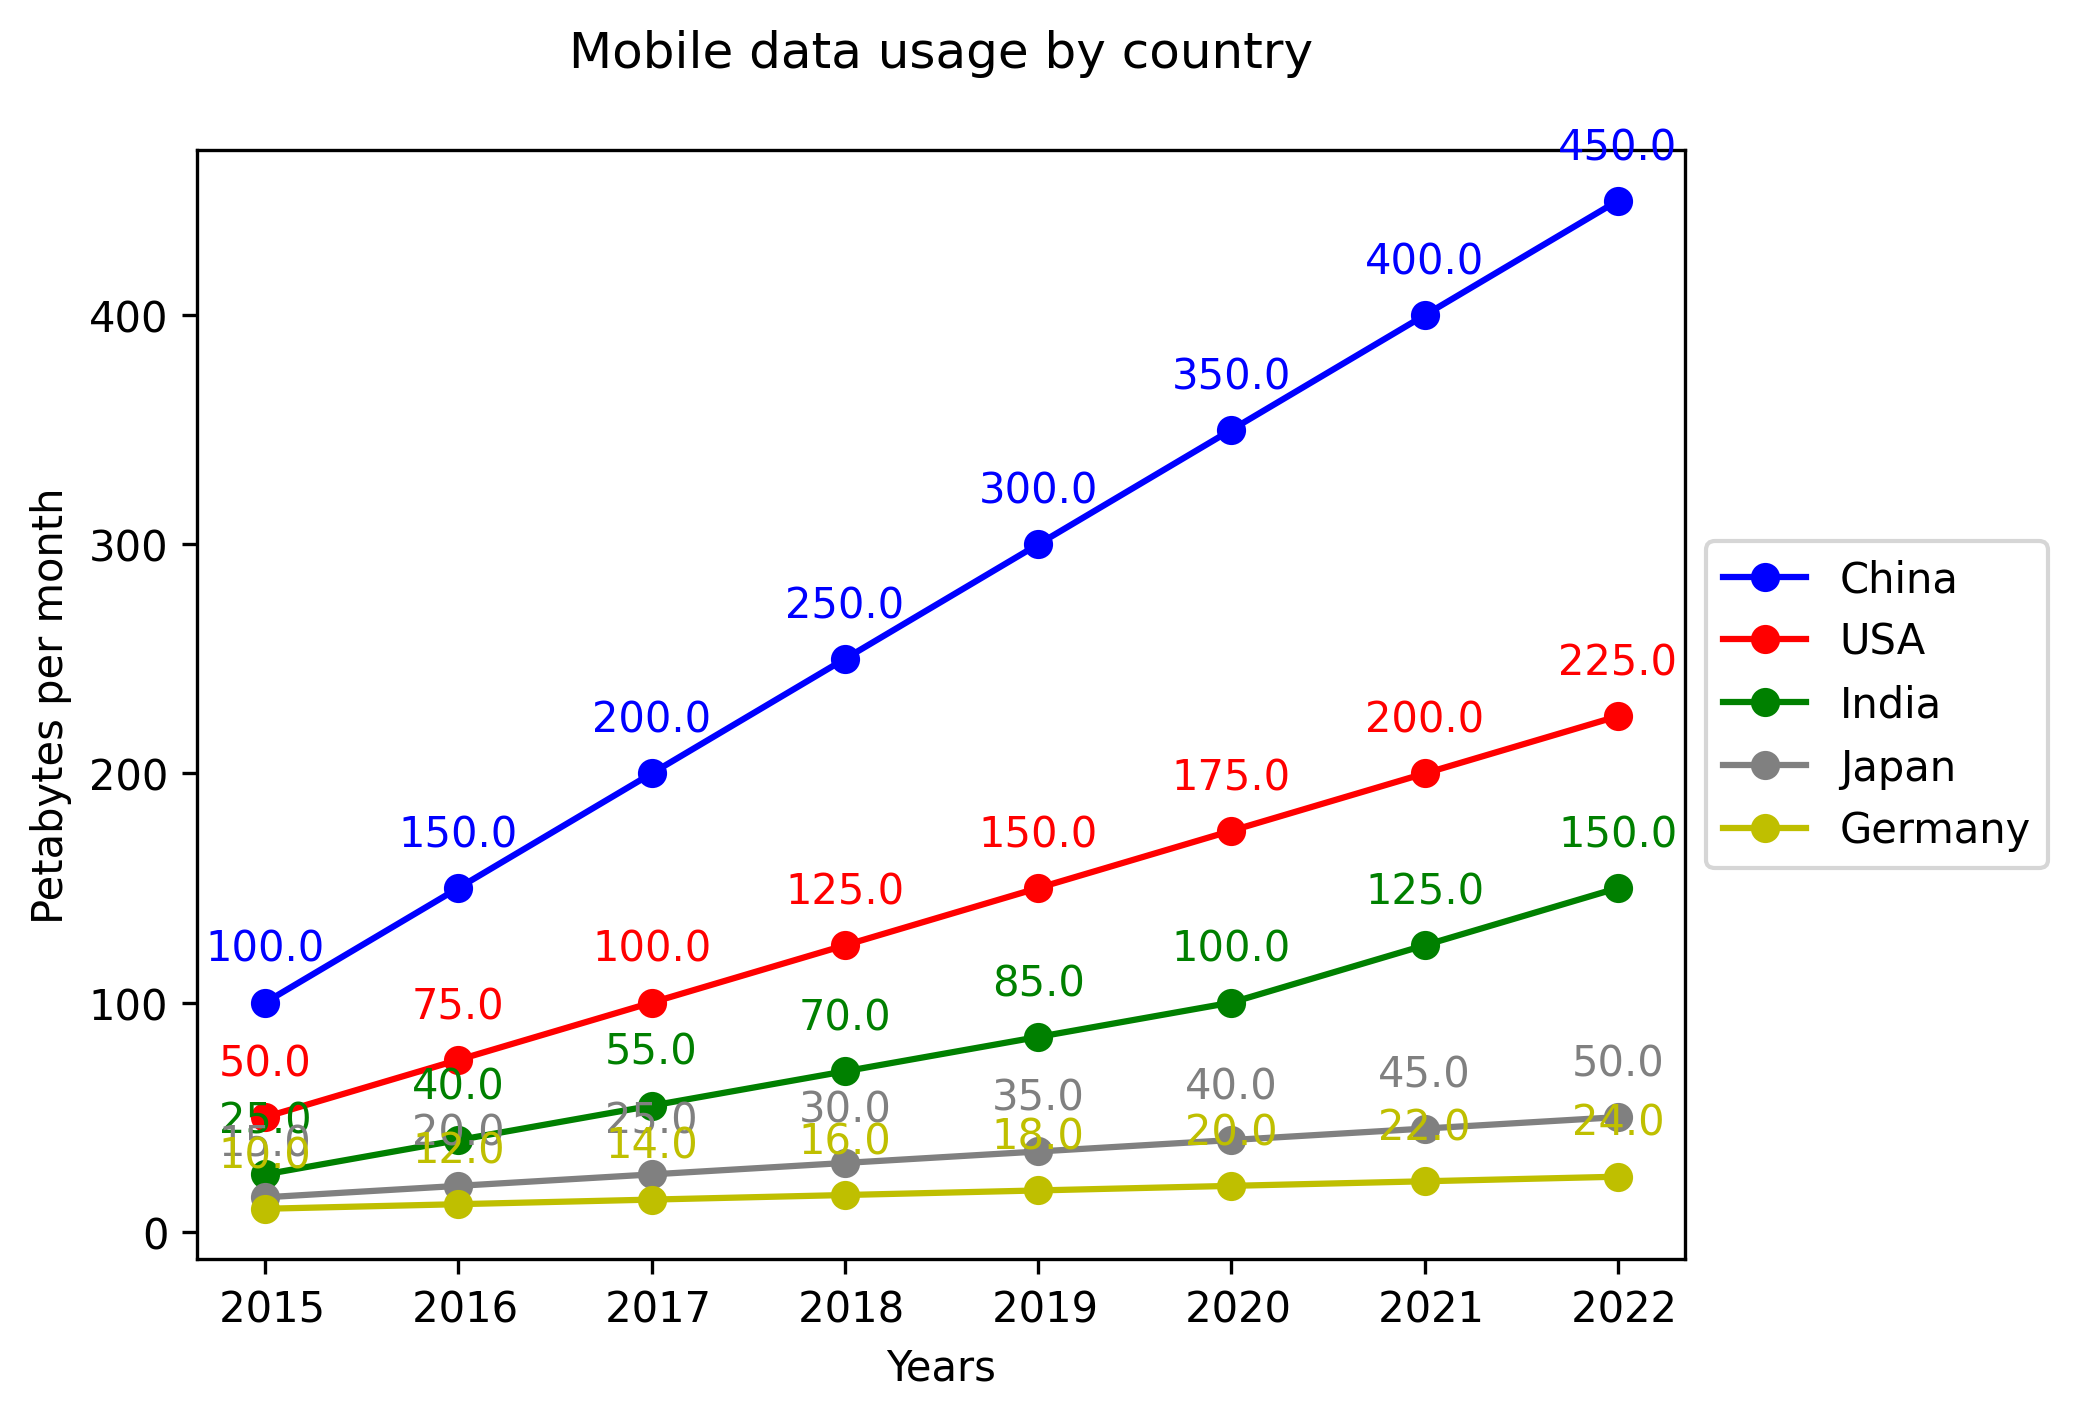

In [3]:
from IPython import display as D

img_path = '../examples/line.png'
D.display(D.Image(filename=img_path, width=490, height=490))

Set max length to 4096


/data/FinAi_Mapping_Knowledge/qiyiyan/miniconda3/envs/intern_clean/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


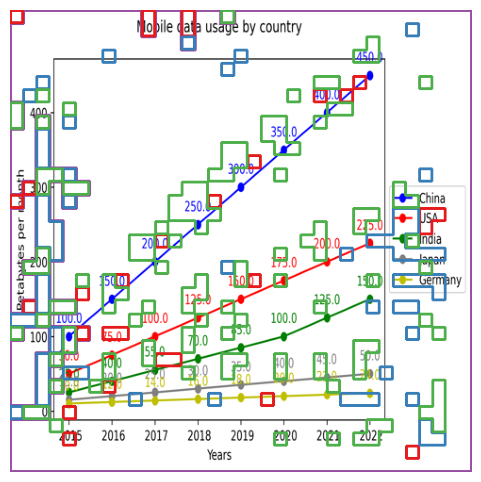

In [4]:
hf_path = 'YOUR_LOCAL_PATH_TO_CHARTMOE_HF'
tester = Expert_Distribution(hf_path)
plot_edge_on_chart(tester, img_path)